In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional

In [2]:
df = pd.read_csv('data/heart_dataset.csv')
df.head()

,HeartRate,BloodOxygenLevel,BodyTemperature,RiskLevel
0,57,100,42,0
1,57,100,41,0
2,57,100,40,0
3,57,100,39,0
4,57,100,38,0


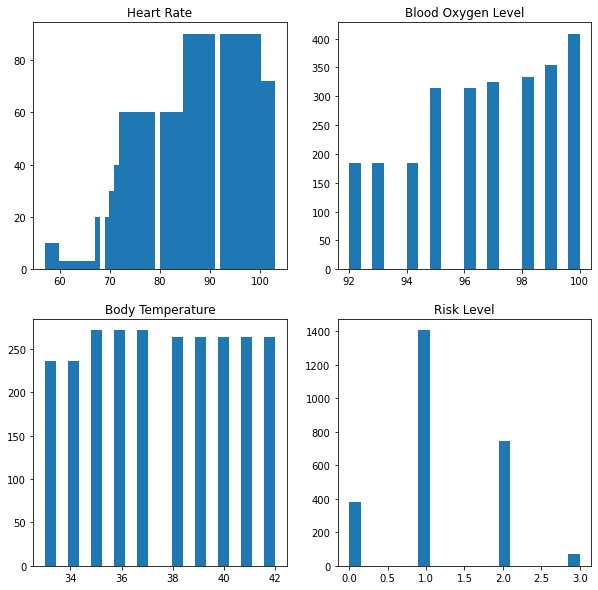

In [3]:
plt.subplots(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.hist(df['HeartRate'], bins=50)
plt.title('Heart Rate')

plt.subplot(2, 2, 2)
plt.hist(df['BloodOxygenLevel'], bins=20)
plt.title('Blood Oxygen Level')

plt.subplot(2, 2, 3)
plt.hist(df['BodyTemperature'], bins=20)
plt.title('Body Temperature')

plt.subplot(2, 2, 4)
plt.hist(df['RiskLevel'], bins=20)
plt.title('Risk Level')

plt.show()

In [13]:
# process_data

'''
Process data which capable for feeding into GRU model
'''

def process_data(
                df, 
                n_steps=50, 
                n_features=3
                ):
    data = df.values
    X, Y = data[:, :-1], data[:, -1]

    scalar = StandardScaler()
    scalar.fit(X)

    X = scalar.transform(X)
    with open('weights/scalar - risk_prediction.pkl', 'wb') as f:
        pickle.dump(scalar, f)

    n_samples = len(X)
    Xts = np.zeros((n_samples, n_steps, n_features))
    Yts = np.zeros((n_samples, 1))

    for i in range(n_samples-n_steps):
        Xts[i] = X[i:i+n_steps]
        Yts[i] = Y[i+n_steps-1]

    Xts = Xts.squeeze()
    Yts = Yts.squeeze()

    return Xts, Yts

In [14]:
X, Y = process_data(df)
X, Y = shuffle(X, Y)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.2, 
                                                random_state=42
                                                )

Ytrain = tf.keras.utils.to_categorical(Ytrain)
Ytest = tf.keras.utils.to_categorical(Ytest)

In [6]:
def TimeSeriesModel(
                    n_steps=50, 
                    n_features=3, 
                    n_outputs=4
                    ):
    model = Sequential()
    model.add(Bidirectional(GRU(128, activation='relu'), input_shape=(n_steps, n_features))),
    model.add(Dense(32, activation='relu')),
    model.add(Dropout(0.2)),

    model.add(Dense(n_outputs, activation='softmax'))
    return model

In [7]:
model = TimeSeriesModel()
model.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=[
                    tf.keras.metrics.CategoricalAccuracy(),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()
                    ])
model.summary()


early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_loss',
                                                patience=10,
                                                restore_best_weights=True
                                                )
history = model.fit(
                Xtrain, Ytrain,
                validation_data=(Xtest, Ytest),
                epochs=100,
                batch_size=32,
                callbacks=[early_stopping]
                )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              102144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 110,500
Trainable params: 110,500
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
65/65 [==============================] - 16s 200ms/step - loss: 0.8493 - categorical_accuracy: 0.6692 - 

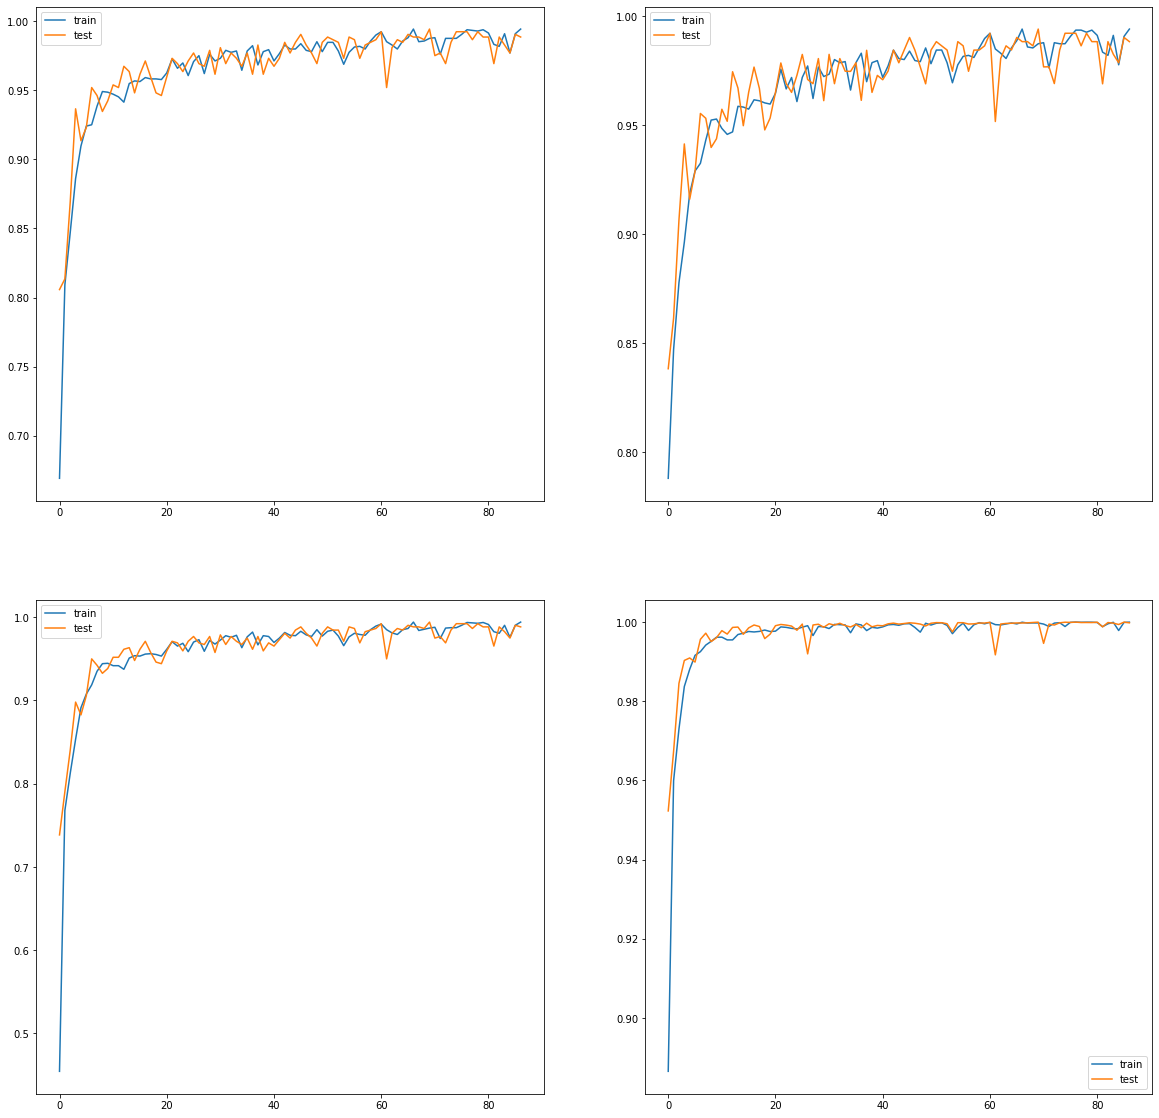

In [8]:
# plot history
plt.subplots(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()

plt.show()

In [9]:
model.save('weights/risk_prediction.h5')

# INFERENCE

In [26]:
risk_level_mapping = {
                    0 : "situation doesn’t exist",
                    1 : "Manageable",
                    2 : "Normal Healthy",
                    3 : "Risky"
                    }

In [27]:
risk_model = tf.keras.models.load_model('weights/risk_prediction.h5')
risk_model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()
                        ])

with open('weights/scalar - risk_prediction.pkl', 'rb') as f:
    scalar = pickle.load(f)

In [28]:
df_all = pd.read_csv('data/heart_dataset.csv')
sample_data = df_all[-50:][["HeartRate","BloodOxygenLevel","BodyTemperature"]]

Xinf = sample_data.values
Xinf = scalar.transform(Xinf)
Xinf = Xinf.reshape(1, 50, 3)

risk_level = risk_model.predict(Xinf).squeeze()
risk_level = np.argmax(risk_level)
risk_level = risk_level_mapping[risk_level]
risk_level

1/1 [==============================] - 0s 357ms/step


'situation doesn’t exist'